In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#imports

In [ ]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import tensorflow_hub as hub
from collections import Counter
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional, GRU, LSTM, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import joblib
import time

In [ ]:
base_dir = '/content/drive/MyDrive/wav/PDFiles/Archive/KAGGLE/Retrain1'

In [ ]:
vggish_model_handle = 'https://tfhub.dev/google/vggish/1'
vggish_layer = hub.KerasLayer(vggish_model_handle, trainable=True)

In [ ]:
def process_audio_file(file_path, sr=16000):
    try:
        audio, _ = librosa.load(file_path, sr=sr)
        if audio.ndim > 1:
            audio = np.mean(audio, axis=1)
        if np.max(audio) < 0.01:
            print(f"File {file_path} is silent or low volume, skipping.")
            return None, None
        audio = librosa.util.normalize(audio)
        non_silent_intervals = librosa.effects.split(audio, top_db=20)
        audio = np.concatenate([audio[start:end] for start, end in non_silent_intervals])
        return audio, os.path.basename(os.path.dirname(file_path))
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")
        return None, None

def load_and_process_files(file_paths, sr=16000):
    with ThreadPoolExecutor(max_workers=8) as executor:
        results = list(tqdm(executor.map(lambda fp: process_audio_file(fp, sr), file_paths), total=len(file_paths)))
    audios, labels = zip(*filter(lambda x: x[0] is not None, results))
    return audios, labels

In [ ]:
supported_extensions = ('.wav', '.mp3', '.m4a', '.aac')

In [ ]:
file_paths = [os.path.join(root, file) for root, _, files in os.walk(base_dir) for file in files if file.lower().endswith(supported_extensions)]

In [ ]:
audios, labels = load_and_process_files(file_paths)

In [ ]:
print(f"Total audio files loaded: {len(audios)}")
print(f"Total labels loaded: {len(labels)}")

Total audio files loaded: 11844
Total labels loaded: 11844


In [ ]:
max_len = 22050 * 20  # 5 seconds at 16 kHz
audios_padded = [np.pad(audio, (0, max_len - len(audio)), 'constant') if len(audio) < max_len else audio[:max_len] for audio in audios]

In [ ]:
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
print(f"Labels encoded. Classes: {le.classes_}")

Labels encoded. Classes: ['FAKE' 'REAL']


In [ ]:
def extract_vggish_features(audio_data):
    return vggish_layer(tf.convert_to_tensor(audio_data, dtype=tf.float32)).numpy()

def extract_custom_features(audio_data):
    mfcc_features = librosa.feature.mfcc(y=audio_data, sr=22050, n_mfcc=20)
    mfcc_features = np.mean(mfcc_features.T, axis=0)  # Take the mean across time

    chroma_features = librosa.feature.chroma_stft(y=audio_data, sr=22050)
    chroma_features = np.mean(chroma_features.T, axis=0)

    spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=22050)
    spectral_contrast = np.mean(spectral_contrast.T, axis=0)

    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=22050)
    mel_spectrogram = np.mean(mel_spectrogram.T, axis=0)

    # Concatenate all features ensuring they have the same dimension
    combined_features = np.concatenate([
        mfcc_features,
        chroma_features,
        spectral_contrast,
        mel_spectrogram,
    ])

    return combined_features

In [ ]:
with ThreadPoolExecutor(max_workers=8) as executor:
    vggish_features = list(tqdm(executor.map(extract_vggish_features, audios_padded), total=len(audios_padded)))

vggish_features = np.array(vggish_features)
vggish_features = np.squeeze(vggish_features)
print(f"VGGish feature extraction completed. Shape: {vggish_features.shape}")

100%|██████████| 11844/11844 [01:11<00:00, 166.38it/s]

VGGish feature extraction completed. Shape: (11844, 28, 128)


In [ ]:
with ThreadPoolExecutor(max_workers=8) as executor:
    custom_features = list(tqdm(executor.map(extract_custom_features, audios_padded), total=len(audios_padded)))

custom_features = np.array(custom_features)
print(f"Custom feature extraction completed. Shape: {custom_features.shape}")

100%|██████████| 11844/11844 [17:50<00:00, 11.06it/s]

Custom feature extraction completed. Shape: (11844, 167)


In [ ]:
num_time_frames = vggish_features.shape[1]
custom_features_expanded = np.repeat(custom_features[:, np.newaxis, :], num_time_frames, axis=1)
print(f"Custom features expanded. Shape: {custom_features_expanded.shape}")

Custom features expanded. Shape: (11844, 28, 167)


In [ ]:
# Concatenate VGGish and custom features along the last axis
features = np.concatenate([vggish_features, custom_features_expanded], axis=2)
print(f"Combined feature extraction completed. Shape: {features.shape}")

Combined feature extraction completed. Shape: (11844, 28, 295)


#EDA

In [ ]:
def plot_waveform(audio, sr=16000, title='Waveform'):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio, sr=sr)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

def overlay_amplitude_envelopes(audio1, label1, audio2, label2, sr=16000, title='Overlay of Amplitude Envelopes'):
    frame_size = 1024
    hop_length = 512
    amplitude_envelope1 = [max(audio1[i:i+frame_size]) for i in range(0, len(audio1), hop_length)]
    amplitude_envelope2 = [max(audio2[i:i+frame_size]) for i in range(0, len(audio2), hop_length)]
    t1 = librosa.frames_to_time(range(len(amplitude_envelope1)), sr=sr, hop_length=hop_length)
    t2 = librosa.frames_to_time(range(len(amplitude_envelope2)), sr=sr, hop_length=hop_length)

    plt.figure(figsize=(10, 4))
    plt.plot(t1, amplitude_envelope1, label=label1)
    plt.plot(t2, amplitude_envelope2, label=label2, color='r')
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

def overlay_zero_crossing_rates(audio1, label1, audio2, label2, sr=16000, title='Overlay of Zero Crossing Rates'):
    zcr1 = librosa.feature.zero_crossing_rate(audio1)[0]
    zcr2 = librosa.feature.zero_crossing_rate(audio2)[0]
    t1 = librosa.frames_to_time(range(len(zcr1)), sr=sr)
    t2 = librosa.frames_to_time(range(len(zcr2)), sr=sr)

    plt.figure(figsize=(10, 4))
    plt.plot(t1, zcr1, label=label1)
    plt.plot(t2, zcr2, label=label2, color='r')
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Zero Crossing Rate')
    plt.legend()
    plt.show()

def overlay_chroma_features(audio1, label1, audio2, label2, sr=16000, title='Overlay of Chroma Features'):
    chroma1 = librosa.feature.chroma_stft(y=audio1, sr=sr)
    chroma2 = librosa.feature.chroma_stft(y=audio2, sr=sr)
    plt.figure(figsize=(10, 8))

    plt.subplot(2, 1, 1)
    librosa.display.specshow(chroma1, y_axis='chroma', x_axis='time', sr=sr)
    plt.colorbar()
    plt.title(f'{label1}')

    plt.subplot(2, 1, 2)
    librosa.display.specshow(chroma2, y_axis='chroma', x_axis='time', sr=sr)
    plt.colorbar()
    plt.title(f'{label2}')

    plt.tight_layout()
    plt.suptitle(title)
    plt.subplots_adjust(top=0.9)
    plt.show()

def overlay_waveforms(audio1, label1, audio2, label2, sr=16000, title='Overlay of Waveforms'):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio1, sr=sr, alpha=0.5, label=label1)
    librosa.display.waveshow(audio2, sr=sr, alpha=0.5, color='r', label=label2)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

def plot_spectrogram(audio, sr=16000, title='Spectrogram'):
    plt.figure(figsize=(10, 4))
    S = librosa.feature.melspectrogram(y=audio, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

def plot_mfcc(audio, sr=16000, title='MFCC'):
    plt.figure(figsize=(10, 4))
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar()
    plt.title(title)
    plt.show()


In [ ]:
fake_indices = [i for i, label in enumerate(labels) if label == 'FAKE'][:3]
real_indices = [i for i, label in enumerate(labels) if label == 'REAL'][:3]


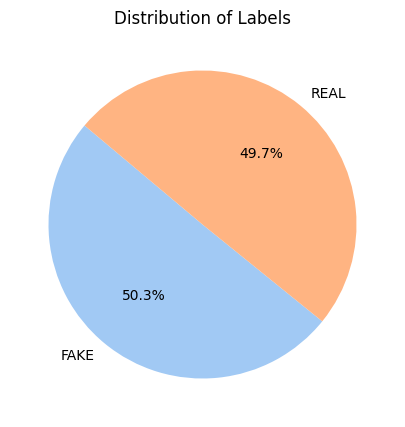

In [ ]:
label_counts = Counter(labels)
plt.figure(figsize=(10, 5))
plt.pie(label_counts.values(), labels=label_counts.keys(), autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title('Distribution of Labels')
plt.show()

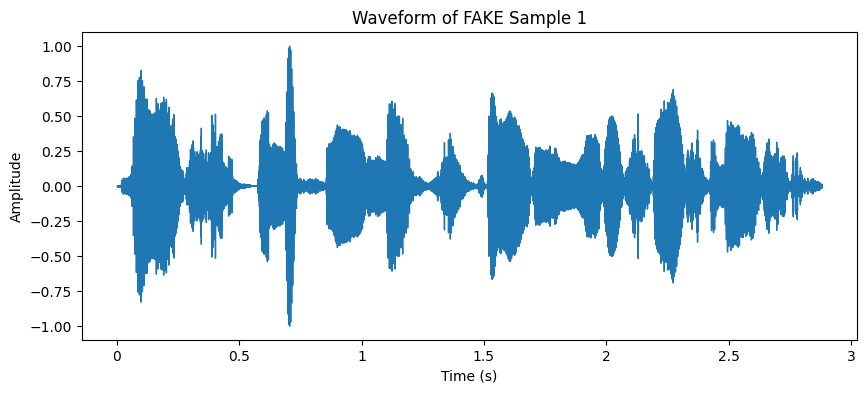

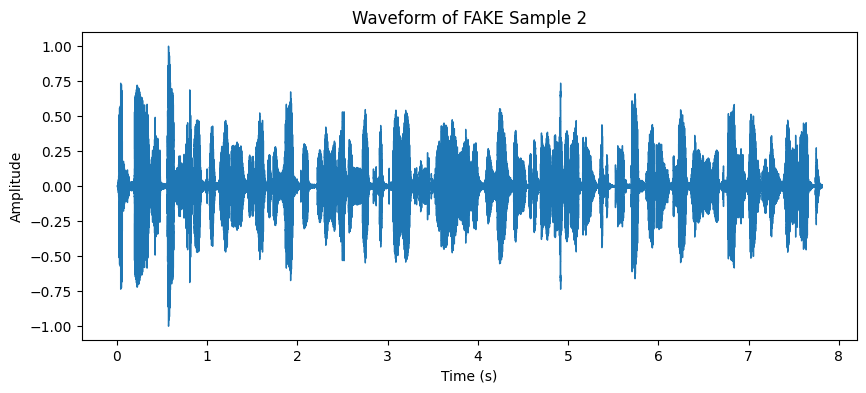

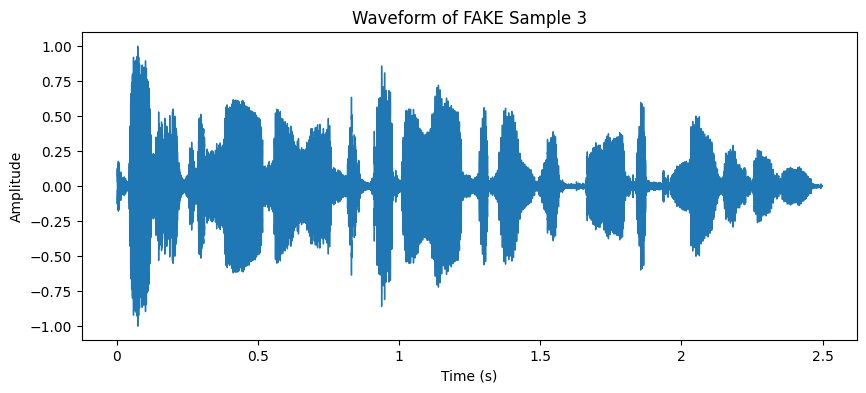

In [ ]:
for i in range(3):
    plot_waveform(audios[i], title=f'Waveform of {labels[i]} Sample {i+1}')

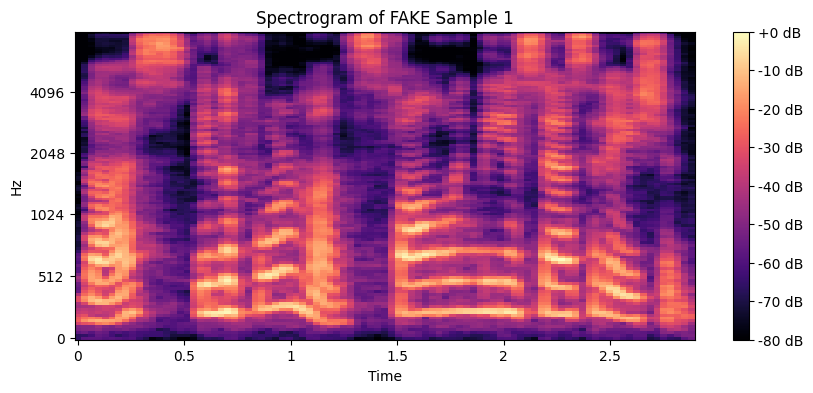

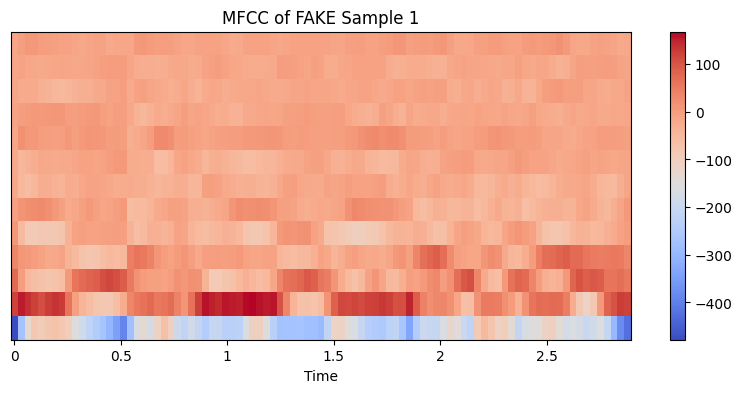

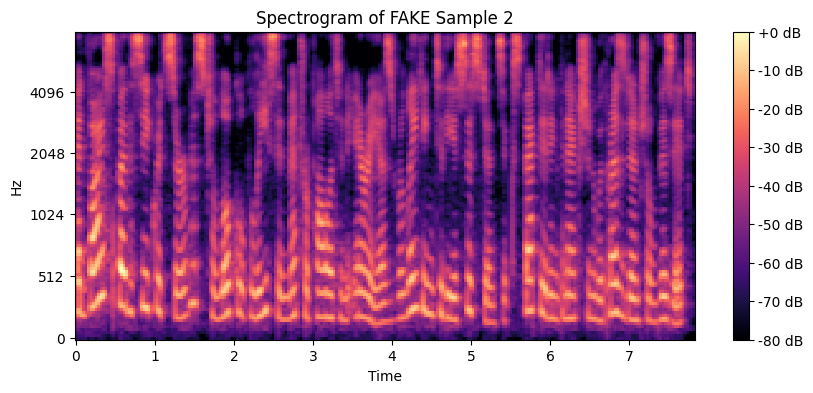

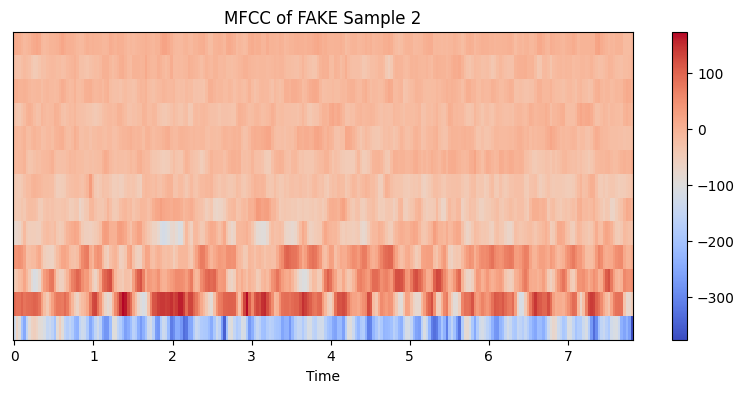

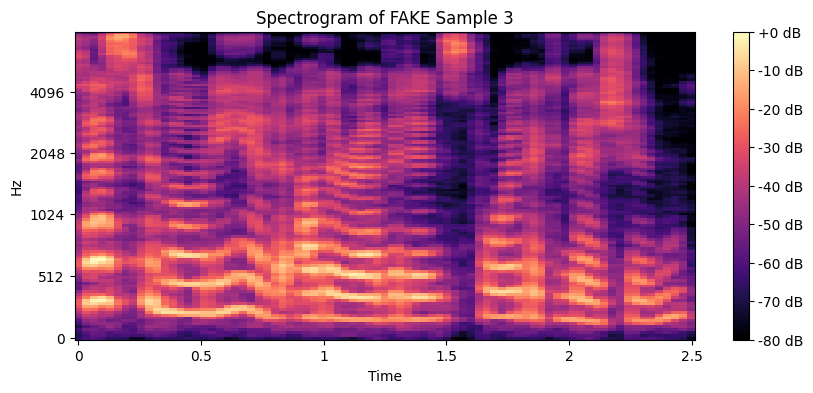

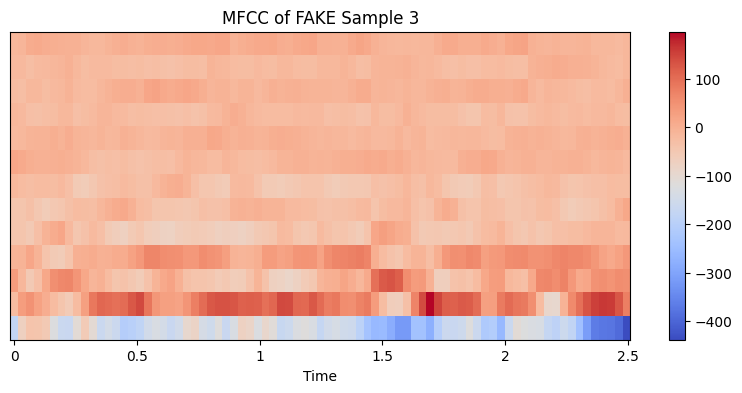

In [ ]:
for idx in fake_indices:
    plot_spectrogram(audios[idx], title=f'Spectrogram of FAKE Sample {idx + 1}')
    plot_mfcc(audios[idx], title=f'MFCC of FAKE Sample {idx + 1}')

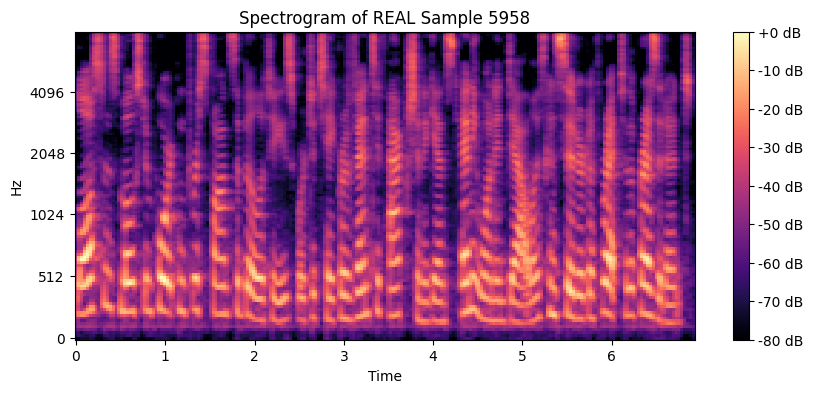

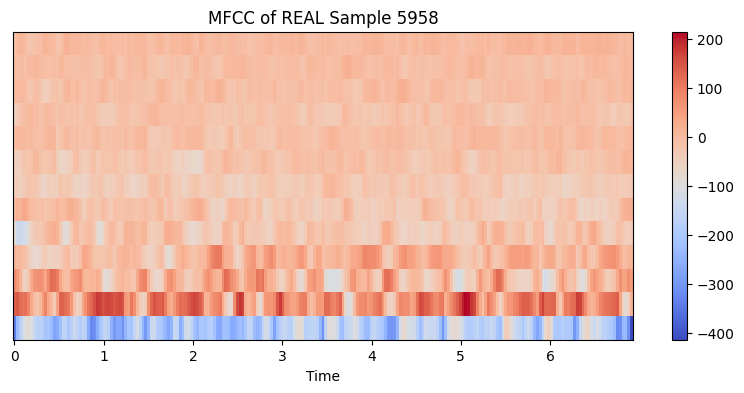

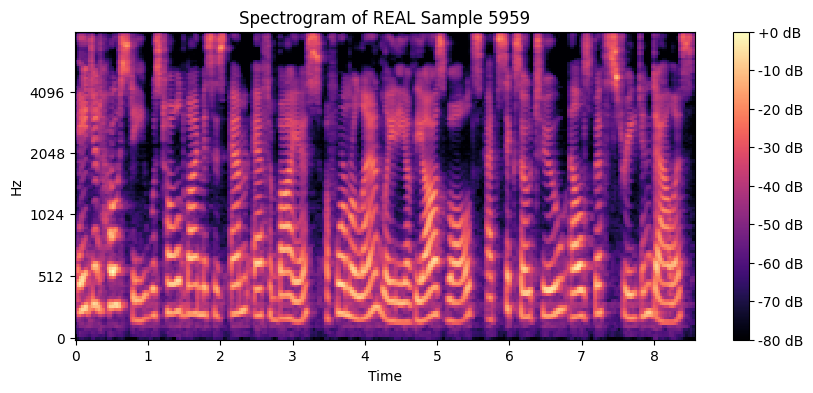

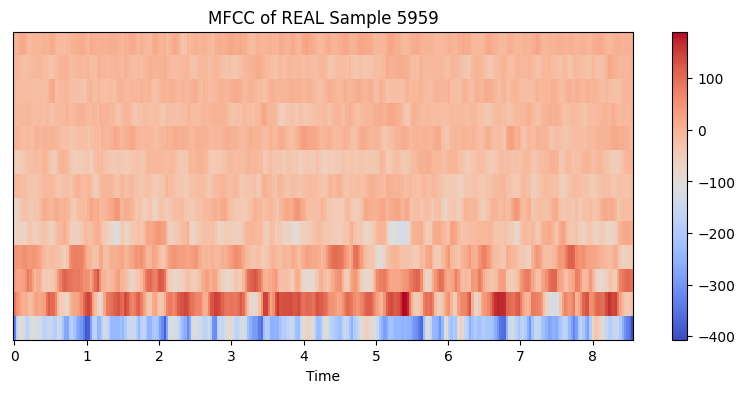

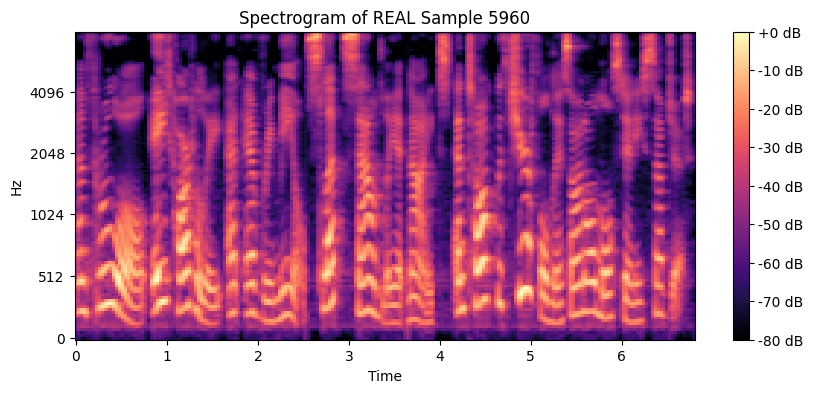

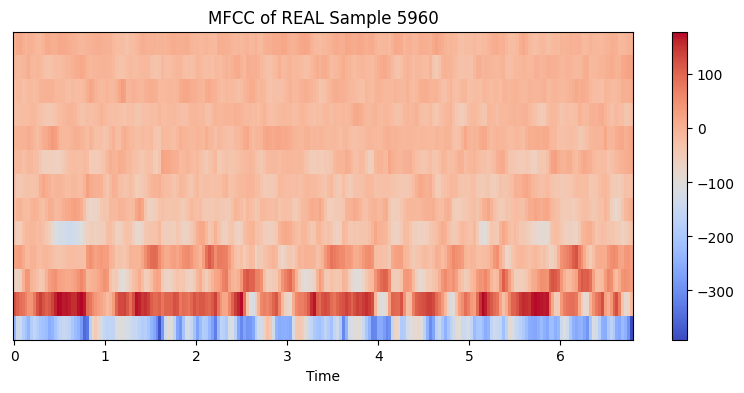

In [ ]:
for idx in real_indices:
    plot_spectrogram(audios[idx], title=f'Spectrogram of REAL Sample {idx + 2}')
    plot_mfcc(audios[idx], title=f'MFCC of REAL Sample {idx + 2}')

#More visible comparison

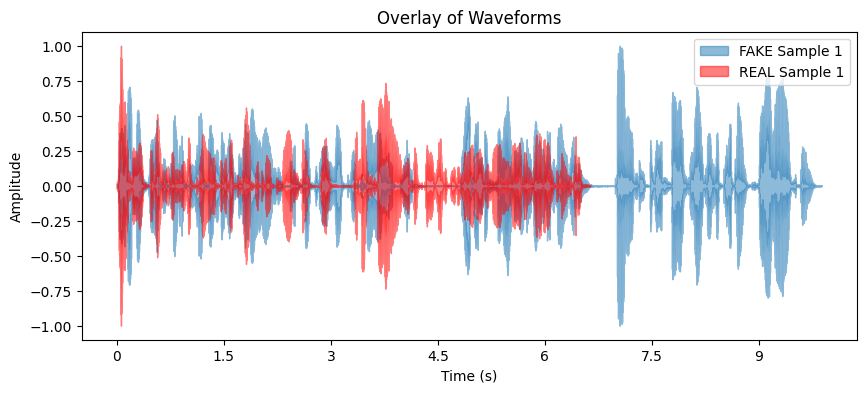

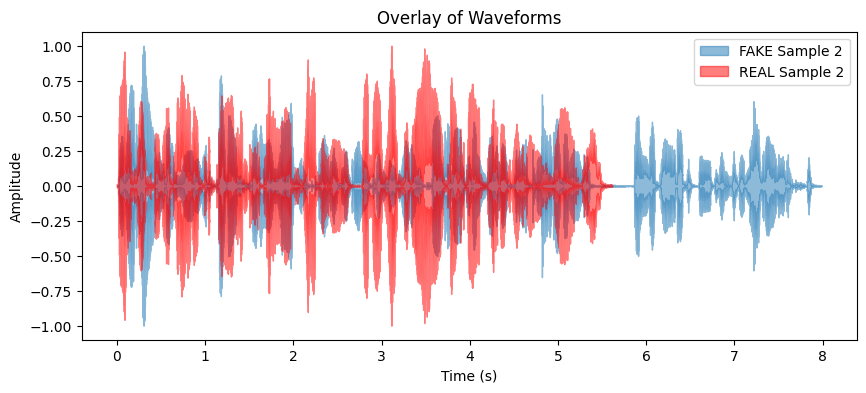

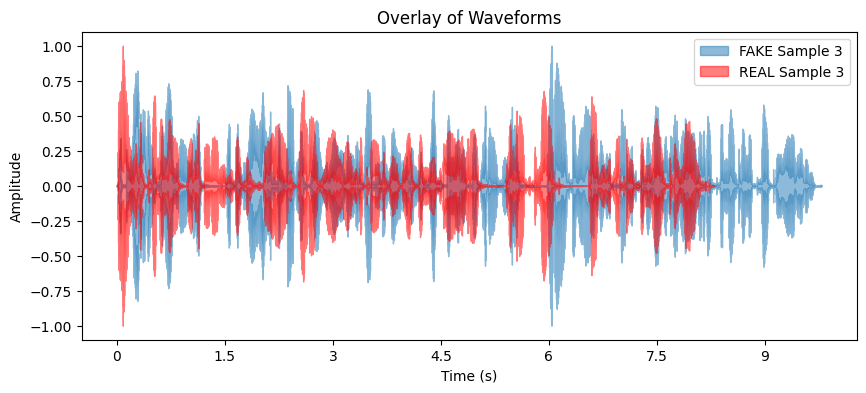

In [ ]:
for i in range(3):
    overlay_waveforms(audios[fake_indices[i]], f'FAKE Sample {i+1}', audios[real_indices[i]], f'REAL Sample {i+1}')

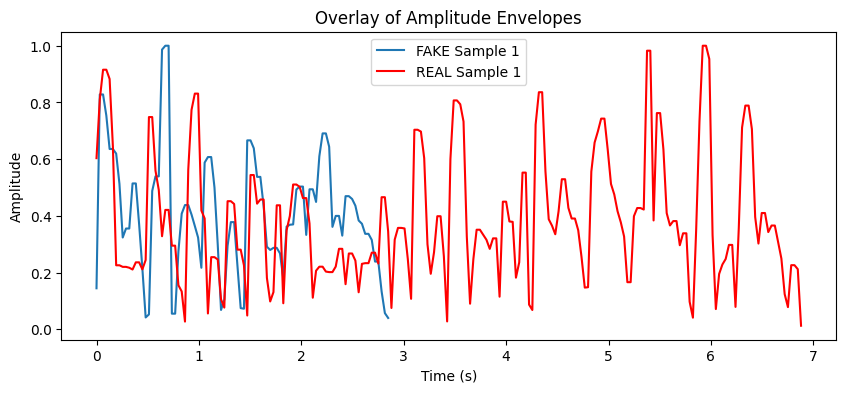

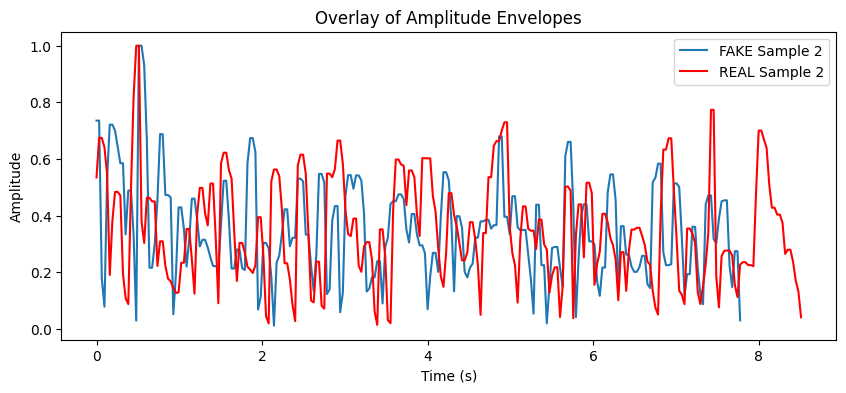

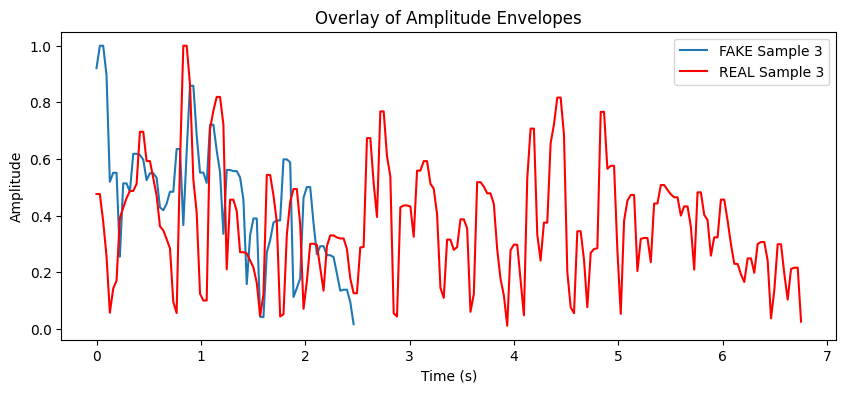

In [ ]:
for i in range(3):
    overlay_amplitude_envelopes(audios[fake_indices[i]], f'FAKE Sample {i+1}', audios[real_indices[i]], f'REAL Sample {i+1}')

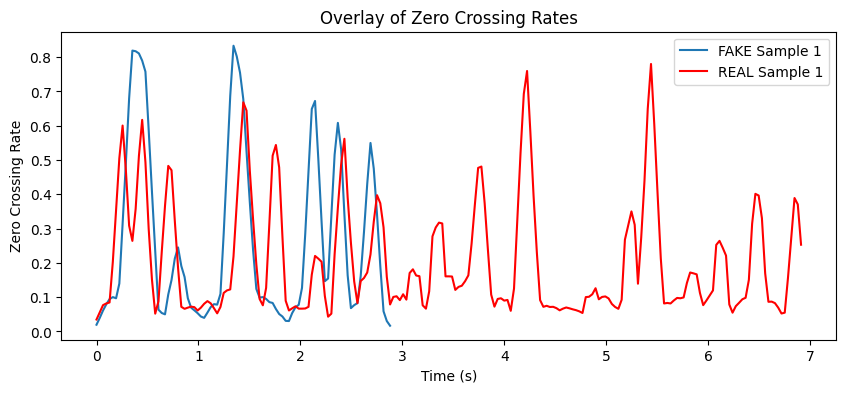

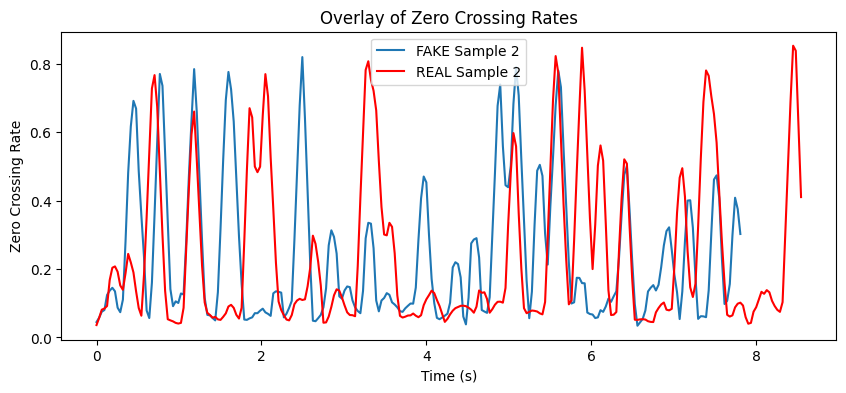

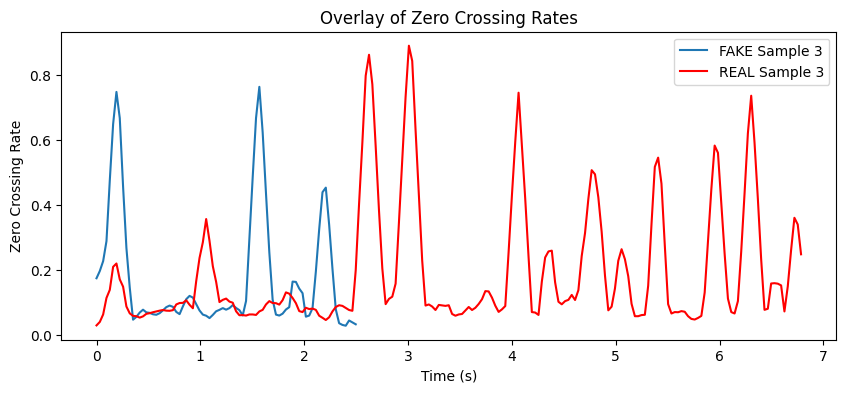

In [ ]:
for i in range(3):
    overlay_zero_crossing_rates(audios[fake_indices[i]], f'FAKE Sample {i+1}', audios[real_indices[i]], f'REAL Sample {i+1}')

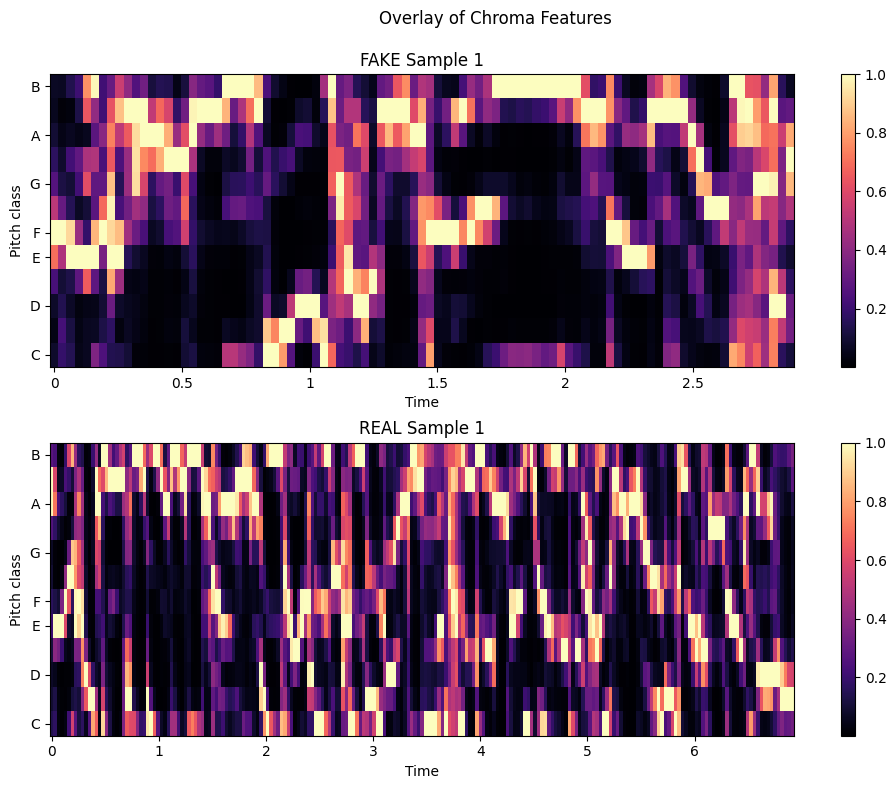

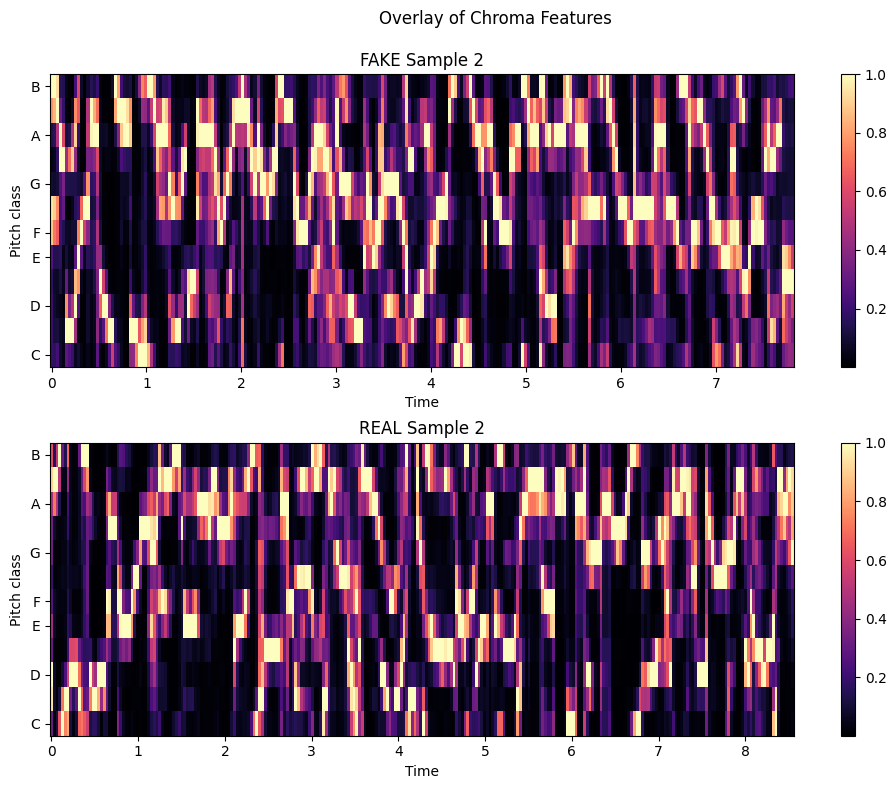

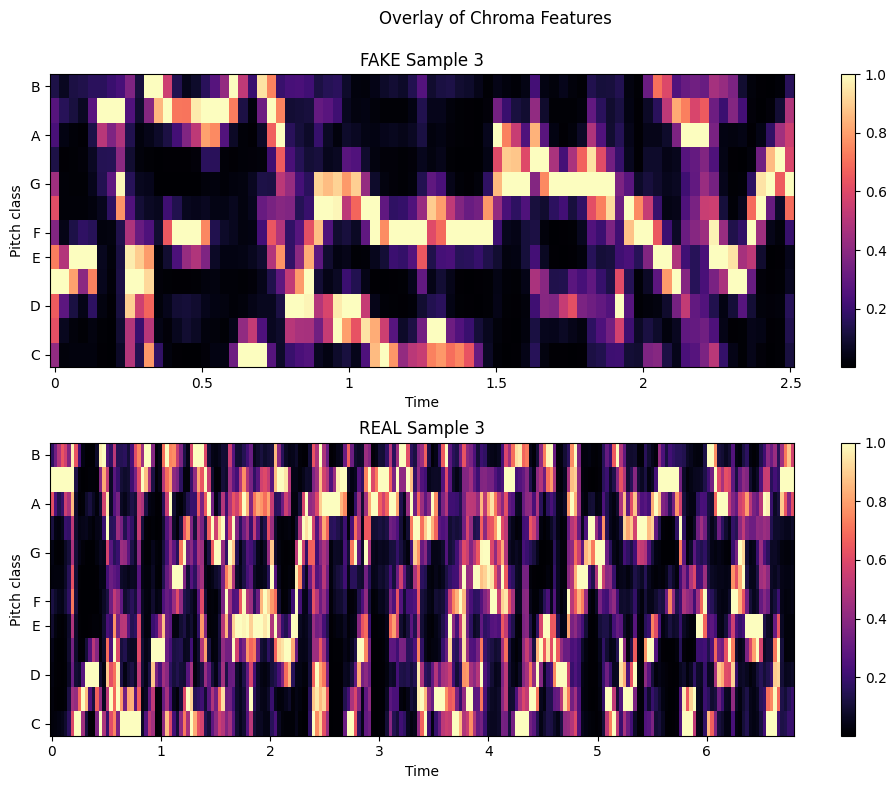

In [ ]:
for i in range(3):overlay_chroma_features(audios[fake_indices[i]], f'FAKE Sample {i+1}', audios[real_indices[i]], f'REAL Sample {i+1}')

#Model Training

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(features, labels_encoded, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 8527
Validation set size: 2132
Test set size: 1185


#D1

In [ ]:
model1 = Sequential()
model1.add(Input(shape=(features.shape[1], features.shape[2])))

model1.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling1D(pool_size=2))
model1.add(Dropout(0.3))

model1.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling1D(pool_size=2))
model1.add(Dropout(0.3))

model1.add(Conv1D(256, kernel_size=3, activation='relu', padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling1D(pool_size=1))
model1.add(Dropout(0.3))

model1.add(LSTM(128, return_sequences=True))
model1.add(BatchNormalization())
model1.add(Dropout(0.4))

model1.add(LSTM(64))
model1.add(BatchNormalization())
model1.add(Dropout(0.4))

model1.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))

model1.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))

model1.add(Dense(1, activation='sigmoid'))

initial_learning_rate = 0.0005
optimizer = Adam(learning_rate=initial_learning_rate)

model1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 64)            56704     
                                                                 
 batch_normalization (Batch  (None, 28, 64)            256       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 14, 64)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 14, 128)           24704     
                                                                 
 batch_normalization_1 (Bat  (None, 14, 128)           5

In [ ]:
early_stopping2 = EarlyStopping(patience=15, restore_best_weights=True)
model_checkpoint2 = ModelCheckpoint('bestlstm.keras', save_best_only=True)
reduce_lr2 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [ ]:
start_time = time.time()
history2 = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, batch_size=32, callbacks=[early_stopping2, model_checkpoint2, reduce_lr2])
training_time = time.time() - start_time
print(f"Training Time: {training_time} seconds")

In [ ]:
model1 = load_model('bestlstm.keras')
predictions = model1.predict(X_test)
predicted_classes = (predictions > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, predicted_classes)
misclassification_rate = 1 - accuracy_score(y_test, predicted_classes)
print(f"Misclassification Rate: {misclassification_rate}")

model_size = os.path.getsize('bestlstm.keras')
print(f"Model Storage Consumption: {model_size} bytes")

start_inference = time.time()
_ = model1.predict(X_test)
inference_time = time.time() - start_inference
average_inference_time = inference_time / len(X_test)
print(f"Performance: {average_inference_time:.6f} seconds")

fpr, tpr, thresholds = roc_curve(y_test, predictions)
frr = 1 - tpr
eer_threshold = thresholds[np.nanargmin(np.abs(fpr - frr))]
eer = fpr[np.nanargmin(np.abs(fpr - frr))]
print(f"Functionality (EER): {eer:.4f} at threshold {eer_threshold:.4f}")

38/38 [==============================] - 1s 7ms/step
Misclassification Rate: 0.059915611814346015
Model Storage Consumption: 5863494 bytes
38/38 [==============================] - 0s 3ms/step
Performance: 0.000243 seconds
Functionality (EER): 0.0673 at threshold 0.6750


#plots

In [ ]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

67/67 [==============================] - 0s 3ms/step
Validation Accuracy: 0.9441838649155723


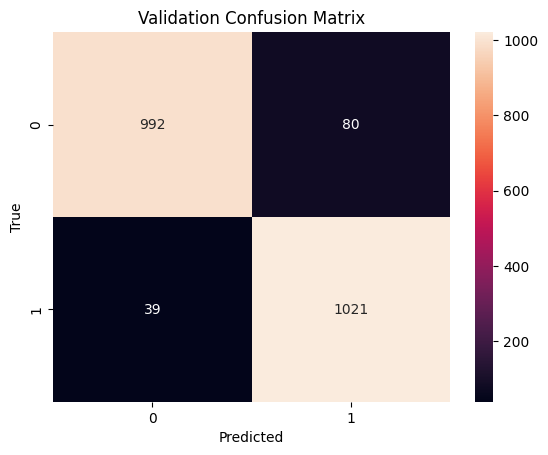

In [ ]:
y_val_pred = model1.predict(X_val)
y_val_pred_labels = (y_val_pred > 0.5).astype(int)

val_accuracy = accuracy_score(y_val, y_val_pred_labels)
val_conf_matrix = confusion_matrix(y_val, y_val_pred_labels)

print(f"Validation Accuracy: {val_accuracy}")
sns.heatmap(val_conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Validation Confusion Matrix')
plt.show()

38/38 [==============================] - 0s 3ms/step
Test Accuracy: 0.940084388185654


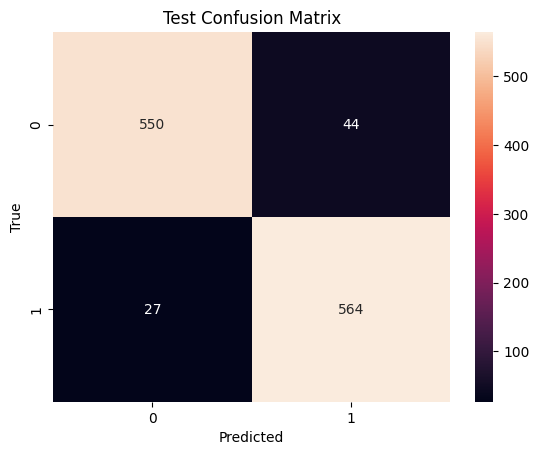

In [ ]:
y_test_pred = model1.predict(X_test)
y_test_pred_labels = (y_test_pred > 0.5).astype(int)

test_accuracy = accuracy_score(y_test, y_test_pred_labels)
test_conf_matrix = confusion_matrix(y_test, y_test_pred_labels)

print(f"Test Accuracy: {test_accuracy}")
sns.heatmap(test_conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

#D2

In [ ]:
model3 = Sequential()
model3.add(Input(shape=(features.shape[1], features.shape[2])))

model3.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPooling1D(pool_size=2))
model3.add(Dropout(0.3))

model3.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPooling1D(pool_size=2))
model3.add(Dropout(0.3))

model3.add(Conv1D(256, kernel_size=3, activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPooling1D(pool_size=1))
model3.add(Dropout(0.3))

model3.add(Bidirectional(LSTM(128, return_sequences=True)))
model3.add(BatchNormalization())
model3.add(Dropout(0.4))

model3.add(Bidirectional(LSTM(64)))
model3.add(BatchNormalization())
model3.add(Dropout(0.4))

model3.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))

model3.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))

model3.add(Dense(1, activation='sigmoid'))

initial_learning_rate = 0.0005
optimizer = Adam(learning_rate=initial_learning_rate)

model3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 28, 64)            56704     
                                                                 
 batch_normalization_7 (Bat  (None, 28, 64)            256       
 chNormalization)                                                
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 14, 64)            0         
 g1D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 14, 64)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 14, 128)           24704     
                                                                 
 batch_normalization_8 (Bat  (None, 14, 128)          

In [ ]:
early_stopping1 = EarlyStopping(patience=15, restore_best_weights=True)
model_checkpoint1 = ModelCheckpoint('bestbilstm.keras', save_best_only=True)
reduce_lr1 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [ ]:
start_time = time.time()
history1 = model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, batch_size=32, callbacks=[early_stopping2, model_checkpoint2, reduce_lr2])
training_time = time.time() - start_time
print(f"Training Time: {training_time} seconds")

In [ ]:
model3 = load_model('bestlstm.keras')
predictions = model3.predict(X_test)
predicted_classes = (predictions > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, predicted_classes)
misclassification_rate = 1 - accuracy_score(y_test, predicted_classes)
print(f"Misclassification Rate: {misclassification_rate}")

model_size = os.path.getsize('bestlstm.keras')
print(f"Model Storage Consumption: {model_size} bytes")

start_inference = time.time()
_ = model3.predict(X_test)
inference_time = time.time() - start_inference
average_inference_time = inference_time / len(X_test)
print(f"Performance: {average_inference_time:.6f} seconds")

fpr, tpr, thresholds = roc_curve(y_test, predictions)
frr = 1 - tpr
eer_threshold = thresholds[np.nanargmin(np.abs(fpr - frr))]
eer = fpr[np.nanargmin(np.abs(fpr - frr))]
print(f"Functionality (EER): {eer:.4f} at threshold {eer_threshold:.4f}")

38/38 [==============================] - 1s 3ms/step
Misclassification Rate: 0.059915611814346015
Model Storage Consumption: 5863494 bytes
38/38 [==============================] - 0s 4ms/step
Performance: 0.000255 seconds
Functionality (EER): 0.0673 at threshold 0.6750


#plots

In [ ]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

67/67 [==============================] - 0s 3ms/step
Validation Accuracy: 0.9441838649155723


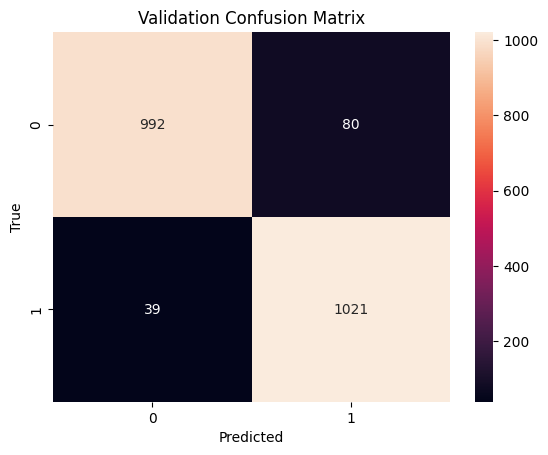

In [ ]:
y_val_pred = model3.predict(X_val)
y_val_pred_labels = (y_val_pred > 0.5).astype(int)

val_accuracy = accuracy_score(y_val, y_val_pred_labels)
val_conf_matrix = confusion_matrix(y_val, y_val_pred_labels)

print(f"Validation Accuracy: {val_accuracy}")
sns.heatmap(val_conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Validation Confusion Matrix')
plt.show()

38/38 [==============================] - 0s 3ms/step
Test Accuracy: 0.940084388185654


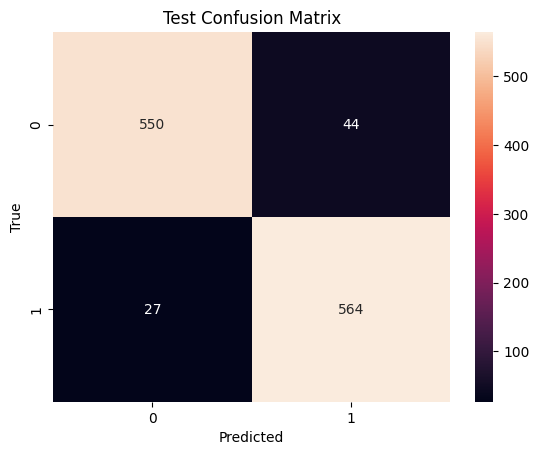

In [ ]:
y_test_pred = model3.predict(X_test)
y_test_pred_labels = (y_test_pred > 0.5).astype(int)

test_accuracy = accuracy_score(y_test, y_test_pred_labels)
test_conf_matrix = confusion_matrix(y_test, y_test_pred_labels)

print(f"Test Accuracy: {test_accuracy}")
sns.heatmap(test_conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

#D3

In [ ]:
model0 = Sequential()
model0.add(Input(shape=(features.shape[1], features.shape[2])))

model0.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model0.add(BatchNormalization())
model0.add(MaxPooling1D(pool_size=2))
model0.add(Dropout(0.3))

model0.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model0.add(BatchNormalization())
model0.add(MaxPooling1D(pool_size=2))
model0.add(Dropout(0.3))

model0.add(Conv1D(256, kernel_size=3, activation='relu', padding='same'))
model0.add(BatchNormalization())
model0.add(MaxPooling1D(pool_size=1))
model0.add(Dropout(0.3))

model0.add(Bidirectional(GRU(128, return_sequences=True)))
model0.add(BatchNormalization())
model0.add(Dropout(0.4))

model0.add(Bidirectional(GRU(64)))
model0.add(BatchNormalization())
model0.add(Dropout(0.4))

model0.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model0.add(BatchNormalization())
model0.add(Dropout(0.5))

model0.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model0.add(BatchNormalization())
model0.add(Dropout(0.5))

model0.add(Dense(1, activation='sigmoid'))

initial_learning_rate = 0.0005
optimizer = Adam(learning_rate=initial_learning_rate)

model0.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model0.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 28, 64)            56704     
                                                                 
 batch_normalization_14 (Ba  (None, 28, 64)            256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 14, 64)            0         
 g1D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 14, 64)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 14, 128)           24704     
                                                                 
 batch_normalization_15 (Ba  (None, 14, 128)          

In [ ]:
early_stopping = EarlyStopping(patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('bestbigru.keras', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [ ]:
start_time = time.time()
history = model0.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, batch_size=32, callbacks=[early_stopping2, model_checkpoint2, reduce_lr2])
training_time = time.time() - start_time
print(f"Training Time: {training_time} seconds")

In [ ]:
model0 = load_model('bestlstm.keras')
predictions = model0.predict(X_test)
predicted_classes = (predictions > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, predicted_classes)
misclassification_rate = 1 - accuracy_score(y_test, predicted_classes)
print(f"Misclassification Rate: {misclassification_rate}")

model_size = os.path.getsize('bestlstm.keras')
print(f"Model Storage Consumption: {model_size} bytes")

start_inference = time.time()
_ = model0.predict(X_test)
inference_time = time.time() - start_inference
average_inference_time = inference_time / len(X_test)
print(f"Performance: {average_inference_time:.6f} seconds")

fpr, tpr, thresholds = roc_curve(y_test, predictions)
frr = 1 - tpr
eer_threshold = thresholds[np.nanargmin(np.abs(fpr - frr))]
eer = fpr[np.nanargmin(np.abs(fpr - frr))]
print(f"Functionality (EER): {eer:.4f} at threshold {eer_threshold:.4f}")

37/37 [==============================] - 1s 3ms/step
Misclassification Rate: 0.04753820033955858
Model Storage Consumption: 8173354 bytes
37/37 [==============================] - 0s 3ms/step
Performance: 0.000179 seconds
Functionality (EER): 0.0532 at threshold 0.4573


#plots

In [ ]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

67/67 [==============================] - 0s 3ms/step
Validation Accuracy: 0.9387081565299387


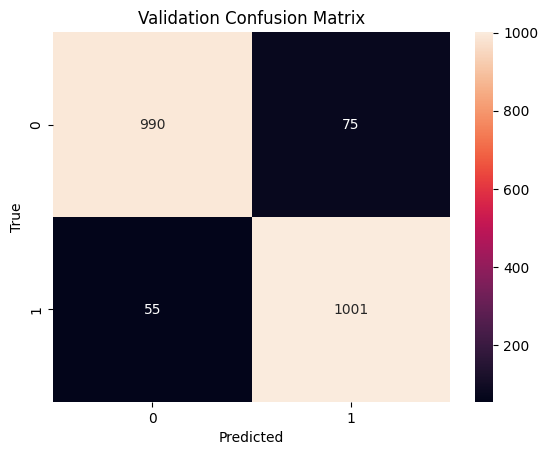

In [ ]:
y_val_pred = model0.predict(X_val)
y_val_pred_labels = (y_val_pred > 0.5).astype(int)

val_accuracy = accuracy_score(y_val, y_val_pred_labels)
val_conf_matrix = confusion_matrix(y_val, y_val_pred_labels)

print(f"Validation Accuracy: {val_accuracy}")
sns.heatmap(val_conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Validation Confusion Matrix')
plt.show()

37/37 [==============================] - 0s 3ms/step
Test Accuracy: 0.9524617996604414


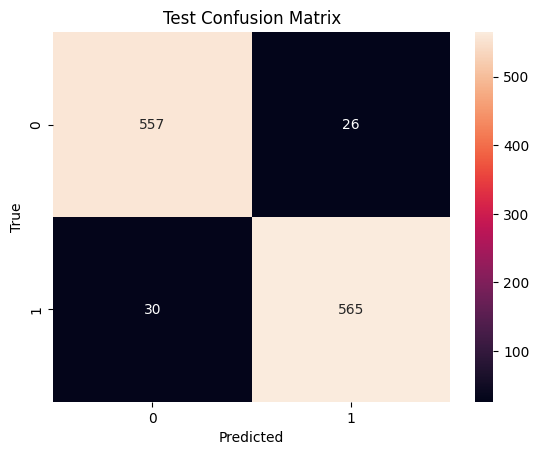

In [ ]:
y_test_pred = model0.predict(X_test)
y_test_pred_labels = (y_test_pred > 0.5).astype(int)

test_accuracy = accuracy_score(y_test, y_test_pred_labels)
test_conf_matrix = confusion_matrix(y_test, y_test_pred_labels)

print(f"Test Accuracy: {test_accuracy}")
sns.heatmap(test_conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

#MANUAL HYPERTUNING DO NOT RUN - ayaw gumana ng gridsearch


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import itertools
import numpy as np

gru_units = [128, 256]
dropout_rates = [0.3, 0.4, 0.5]
learning_rates = [0.0001, 0.0005, 0.001]

results = []


for units, dropout, lr in itertools.product(gru_units, dropout_rates, learning_rates):
    print(f"Training with GRU Units: {units}, Dropout: {dropout}, Learning Rate: {lr}")

    model3 = Sequential()
    model3.add(Input(shape=(features.shape[1], features.shape[2])))


    model3.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
    model3.add(BatchNormalization())
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Dropout(0.3))

    model3.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
    model3.add(BatchNormalization())
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Dropout(0.3))

    model3.add(Conv1D(256, kernel_size=3, activation='relu', padding='same'))
    model3.add(BatchNormalization())
    model3.add(MaxPooling1D(pool_size=1))
    model3.add(Dropout(0.3))

    model3.add(Bidirectional(GRU(units, return_sequences=True)))
    model3.add(BatchNormalization())
    model3.add(Dropout(dropout))

    model3.add(Bidirectional(GRU(units // 2, return_sequences=True)))
    model3.add(BatchNormalization())
    model3.add(Dropout(dropout))

    model3.add(Bidirectional(GRU(units // 4)))
    model3.add(BatchNormalization())
    model3.add(Dropout(dropout))

    model3.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model3.add(BatchNormalization())
    model3.add(Dropout(0.5))

    model3.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model3.add(BatchNormalization())
    model3.add(Dropout(0.5))

    model3.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=lr)
    model3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(patience=15, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('beb.h5', save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

    history = model3.fit(X_train, y_train, validation_data=(X_val, y_val),
                         epochs=150, batch_size=32,
                         callbacks=[early_stopping, model_checkpoint, reduce_lr],
                         verbose=1)  #

    val_loss = min(history.history['val_loss'])
    val_accuracy = max(history.history['val_accuracy'])

    print(f'GRU Units: {units}, Dropout: {dropout}, Learning Rate: {lr}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}\n')

    results.append((units, dropout, lr, val_loss, val_accuracy))

best_result = sorted(results, key=lambda x: x[3])[0]
print(f'Best Hyperparameters - GRU Units: {best_result[0]}, Dropout: {best_result[1]}, Learning Rate: {best_result[2]}, Val Loss: {best_result[3]}, Val Accuracy: {best_result[4]}')

67/67 [==============================] - 2s 4ms/step
Validation Accuracy: 0.9316360207449317


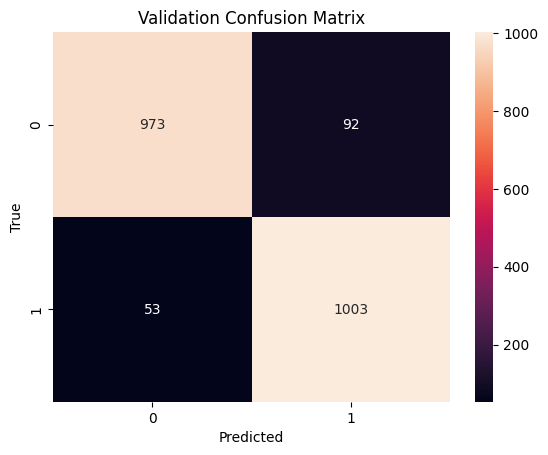

In [ ]:
y_val_pred = model3.predict(X_val)
y_val_pred_labels = (y_val_pred > 0.5).astype(int)

val_accuracy = accuracy_score(y_val, y_val_pred_labels)
val_conf_matrix = confusion_matrix(y_val, y_val_pred_labels)

print(f"Validation Accuracy: {val_accuracy}")
sns.heatmap(val_conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Validation Confusion Matrix')
plt.show()

37/37 [==============================] - 0s 4ms/step
Test Accuracy: 0.9473684210526315


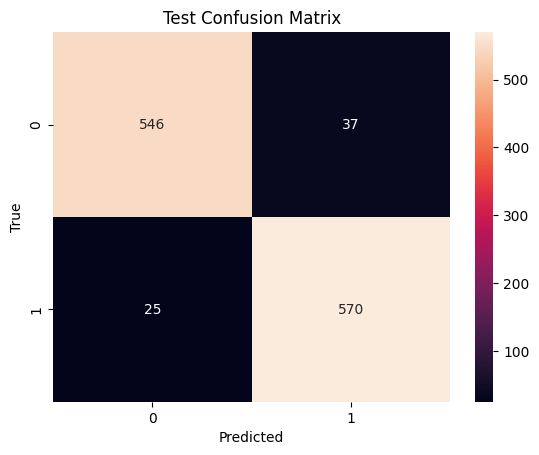

In [ ]:
y_test_pred = model3.predict(X_test)
y_test_pred_labels = (y_test_pred > 0.5).astype(int)

test_accuracy = accuracy_score(y_test, y_test_pred_labels)
test_conf_matrix = confusion_matrix(y_test, y_test_pred_labels)

print(f"Test Accuracy: {test_accuracy}")
sns.heatmap(test_conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

#-----------------------------------------------------------------TESTING

In [6]:
!ls

drive  sample_data


In [ ]:
%cd /content/drive/MyDrive/colab_files

/content/drive/MyDrive/colab_files


In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import load_model
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

vggish_model_handle = 'https://tfhub.dev/google/vggish/1'
vggish_layer = hub.KerasLayer(vggish_model_handle, trainable=False)
model = load_model('/content/drive/MyDrive/wav/PDFiles/BestModels/FinalBiGru(Choice 1).h5')

def process_audio_file(file_path):
    try:
        audio, _ = librosa.load(file_path, sr=16000)
        if audio.ndim > 1:
            audio = np.mean(audio, axis=1)
        if np.max(audio) < 0.01:
            print(f"File {file_path} is silent or low volume, skipping.")
            return None
        audio = librosa.util.normalize(audio)
        return audio
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")
        return None

def extract_vggish_features(audio_data):
    return vggish_layer(tf.convert_to_tensor(audio_data, dtype=tf.float32)).numpy()

def extract_custom_features(audio_data):
    mfcc_features = librosa.feature.mfcc(y=audio_data, sr=16000, n_mfcc=20)
    mfcc_features = np.mean(mfcc_features.T, axis=0)
    chroma_features = librosa.feature.chroma_stft(y=audio_data, sr=16000)
    chroma_features = np.mean(chroma_features.T, axis=0)

    spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=16000)
    spectral_contrast = np.mean(spectral_contrast.T, axis=0)

    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=16000)
    mel_spectrogram = np.mean(mel_spectrogram.T, axis=0)

    combined_features = np.concatenate([
        mfcc_features,
        chroma_features,
        spectral_contrast,
        mel_spectrogram,
    ])

    return combined_features

def pad_to_length(array, target_length, axis=0):
    current_length = array.shape[axis]
    if current_length < target_length:
        pad_width = [(0, 0)] * array.ndim
        pad_width[axis] = (0, target_length - current_length)
        array = np.pad(array, pad_width, mode='constant')
    elif current_length > target_length:
        slices = [slice(None)] * array.ndim
        slices[axis] = slice(0, target_length)
        array = array[tuple(slices)]
    return array

def predict_audio(file_path):
    audio = process_audio_file(file_path)
    if audio is None:
        return "Invalid audio file"

    max_len = 16000 * 5
    target_length = 7

    segments = [audio[i * max_len:(i + 1) * max_len] for i in range(int(np.ceil(len(audio) / max_len)))]
    segments = [np.pad(seg, (0, max_len - len(seg)), 'constant') if len(seg) < max_len else seg for seg in segments]

    with ThreadPoolExecutor(max_workers=8) as executor:
        vggish_features = list(tqdm(executor.map(extract_vggish_features, segments), total=len(segments)))

    vggish_features = np.array(vggish_features)
    if len(vggish_features.shape) == 3 and vggish_features.shape[0] == 1:
        vggish_features = np.squeeze(vggish_features, axis=0)
    vggish_features = pad_to_length(vggish_features, target_length, axis=0)
    print(f"VGGish feature extraction completed. Shape: {vggish_features.shape}")

    with ThreadPoolExecutor(max_workers=8) as executor:
        custom_features = list(tqdm(executor.map(extract_custom_features, segments), total=len(segments)))

    custom_features = np.array(custom_features)
    if len(custom_features.shape) == 3 and custom_features.shape[0] == 1:
        custom_features = np.squeeze(custom_features, axis=0)
    custom_features_expanded = np.repeat(custom_features[:, np.newaxis, :], target_length, axis=1)
    custom_features_expanded = pad_to_length(custom_features_expanded, target_length, axis=1)
    print(f"Custom feature extraction completed. Shape: {custom_features_expanded.shape}")

    if len(vggish_features.shape) == 2:
        vggish_features = np.expand_dims(vggish_features, axis=0)

    if len(custom_features_expanded.shape) == 2:
        custom_features_expanded = np.expand_dims(custom_features_expanded, axis=0)

    features = np.concatenate([vggish_features, custom_features_expanded], axis=-1)
    print(f"Combined feature extraction completed. Shape: {features.shape}")

    predictions = []
    for feature in features:
        feature = np.expand_dims(feature, axis=0)
        prediction = model.predict(feature)
        predictions.append(prediction)

    average_prediction = np.mean(predictions)
    predicted_class = 'REAL' if average_prediction > 0.5 else 'FAKE'
    return predicted_class

def predict_folder(folder_path):
    file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.wav')]
    predictions = {}

    for file_path in tqdm(file_paths, desc="Processing files"):
        predictions[file_path] = predict_audio(file_path)

    return predictions

In [ ]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 7, 64)             56704     
                                                                 
 batch_normalization_28 (Ba  (None, 7, 64)             256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 3, 64)             0         
 ng1D)                                                           
                                                                 
 dropout_35 (Dropout)        (None, 3, 64)             0         
                                                                 
 conv1d_11 (Conv1D)          (None, 3, 128)            24704     
                                                                 
 batch_normalization_29 (Ba  (None, 3, 128)          

In [9]:
new_audio_file_path = '/content/drive/MyDrive/wav/PDFiles/Final-App/real-tested-audio/LJ001-0043.wav'
predicted_class = predict_audio(new_audio_file_path)
print(f"The predicted class for the new audio file is: {predicted_class}")

100%|██████████| 1/1 [00:00<00:00, 78.10it/s]


VGGish feature extraction completed. Shape: (7, 128)


100%|██████████| 1/1 [00:00<00:00, 17.10it/s]


Custom feature extraction completed. Shape: (1, 7, 167)
Combined feature extraction completed. Shape: (1, 7, 295)
1/1 [==============================] - 0s 37ms/step
The predicted class for the new audio file is: REAL


In [ ]:
folder_path = '/content/drive/MyDrive/wav/PDFiles/Archive/KAGGLE/AUDIO/FAKE'
predictions = predict_folder(folder_path)
for file_path, predicted_class in predictions.items():
    print(f"{file_path}: {predicted_class}")

100%|██████████| 1/1 [00:00<00:00, 495.72it/s]


VGGish feature extraction completed. Shape: (7, 128)



100%|██████████| 1/1 [00:00<00:00, 19.48it/s]

Custom feature extraction completed. Shape: (1, 7, 167)
Combined feature extraction completed. Shape: (1, 7, 295)
1/1 [==============================] - 0s 32ms/step



100%|██████████| 1/1 [00:00<00:00, 492.29it/s]


VGGish feature extraction completed. Shape: (7, 128)



100%|██████████| 1/1 [00:00<00:00, 21.79it/s]


Custom feature extraction completed. Shape: (1, 7, 167)
Combined feature extraction completed. Shape: (1, 7, 295)
1/1 [==============================] - 0s 31ms/step


100%|██████████| 1/1 [00:00<00:00, 387.46it/s]


VGGish feature extraction completed. Shape: (7, 128)



100%|██████████| 1/1 [00:00<00:00, 17.77it/s]

Custom feature extraction completed. Shape: (1, 7, 167)
Combined feature extraction completed. Shape: (1, 7, 295)
1/1 [==============================] - 0s 33ms/step



100%|██████████| 1/1 [00:00<00:00, 322.19it/s]


VGGish feature extraction completed. Shape: (7, 128)



100%|██████████| 1/1 [00:00<00:00, 19.56it/s]


Custom feature extraction completed. Shape: (1, 7, 167)
Combined feature extraction completed. Shape: (1, 7, 295)
1/1 [==============================] - 0s 31ms/step


100%|██████████| 1/1 [00:00<00:00, 389.52it/s]


VGGish feature extraction completed. Shape: (7, 128)



100%|██████████| 1/1 [00:00<00:00, 21.32it/s]


Custom feature extraction completed. Shape: (1, 7, 167)
Combined feature extraction completed. Shape: (1, 7, 295)
1/1 [==============================] - 0s 37ms/step


100%|██████████| 1/1 [00:00<00:00, 102.20it/s]


VGGish feature extraction completed. Shape: (7, 128)



100%|██████████| 1/1 [00:00<00:00, 21.67it/s]


Custom feature extraction completed. Shape: (1, 7, 167)
Combined feature extraction completed. Shape: (1, 7, 295)
1/1 [==============================] - 0s 34ms/step


100%|██████████| 1/1 [00:00<00:00, 136.32it/s]


VGGish feature extraction completed. Shape: (7, 128)



100%|██████████| 1/1 [00:00<00:00, 21.14it/s]


Custom feature extraction completed. Shape: (1, 7, 167)
Combined feature extraction completed. Shape: (1, 7, 295)
1/1 [==============================] - 0s 33ms/step


100%|██████████| 1/1 [00:00<00:00, 105.74it/s]


VGGish feature extraction completed. Shape: (7, 128)



100%|██████████| 1/1 [00:00<00:00, 22.86it/s]


Custom feature extraction completed. Shape: (1, 7, 167)
Combined feature extraction completed. Shape: (1, 7, 295)
1/1 [==============================] - 0s 31ms/step


100%|██████████| 1/1 [00:00<00:00, 98.68it/s]


VGGish feature extraction completed. Shape: (7, 128)



100%|██████████| 1/1 [00:00<00:00, 21.59it/s]


Custom feature extraction completed. Shape: (1, 7, 167)
Combined feature extraction completed. Shape: (1, 7, 295)
1/1 [==============================] - 0s 31ms/step


100%|██████████| 1/1 [00:00<00:00, 309.91it/s]


VGGish feature extraction completed. Shape: (7, 128)



100%|██████████| 1/1 [00:00<00:00, 25.78it/s]


Custom feature extraction completed. Shape: (1, 7, 167)
Combined feature extraction completed. Shape: (1, 7, 295)
1/1 [==============================] - 0s 31ms/step


100%|██████████| 1/1 [00:00<00:00, 128.85it/s]


VGGish feature extraction completed. Shape: (7, 128)



100%|██████████| 1/1 [00:00<00:00, 22.44it/s]


Custom feature extraction completed. Shape: (1, 7, 167)
Combined feature extraction completed. Shape: (1, 7, 295)
1/1 [==============================] - 0s 32ms/step


100%|██████████| 1/1 [00:00<00:00, 7145.32it/s]


VGGish feature extraction completed. Shape: (7, 128)



100%|██████████| 1/1 [00:00<00:00, 21.78it/s]

Custom feature extraction completed. Shape: (1, 7, 167)
Combined feature extraction completed. Shape: (1, 7, 295)
1/1 [==============================] - 0s 30ms/step



100%|██████████| 1/1 [00:00<00:00, 107.65it/s]


VGGish feature extraction completed. Shape: (7, 128)



100%|██████████| 1/1 [00:00<00:00, 22.52it/s]


Custom feature extraction completed. Shape: (1, 7, 167)
Combined feature extraction completed. Shape: (1, 7, 295)
1/1 [==============================] - 0s 35ms/step


100%|██████████| 1/1 [00:00<00:00, 97.89it/s]


VGGish feature extraction completed. Shape: (7, 128)



100%|██████████| 1/1 [00:00<00:00, 25.75it/s]


Custom feature extraction completed. Shape: (1, 7, 167)
Combined feature extraction completed. Shape: (1, 7, 295)
1/1 [==============================] - 0s 31ms/step


100%|██████████| 1/1 [00:00<00:00, 481.44it/s]


VGGish feature extraction completed. Shape: (7, 128)



100%|██████████| 1/1 [00:00<00:00, 22.04it/s]


Custom feature extraction completed. Shape: (1, 7, 167)
Combined feature extraction completed. Shape: (1, 7, 295)
1/1 [==============================] - 0s 31ms/step


100%|██████████| 2/2 [00:00<00:00, 327.23it/s]


VGGish feature extraction completed. Shape: (7, 5, 128)



  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Processing files:  15%|█▌        | 15/97 [00:02<00:16,  5.06it/s]

Custom feature extraction completed. Shape: (2, 7, 167)


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 7 and the array at index 1 has size 2